# Parameter Optimization for Gene Set Recovery

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Appendix Figure S4B-D

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sts
from tqdm import tqdm
import re
from neteval.network_statistics import NetworkStats, load_network_names

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25


In [3]:
gitdir = os.path.dirname(os.getcwd())
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))

### Load data

Load the precomputed performance scores for each interactome with the MSigDB gene sets.

In [4]:
test_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data', 'DatasetEV6.txt'), sep='\t', index_col=0)

In [5]:
print(f'Range of sampling proportions (p): [{", ".join([str(x) for x in test_df.p.sort_values().unique()])}]')
print(f'Range of propagation constants (alpha): [{", ".join([str(x) for x in test_df.alpha.sort_values().unique()])}]')

Range of sampling proportions (p): [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
Range of propagation constants (alpha): [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


### Appendix Figure S4B

Performance Z-score vs parameter values

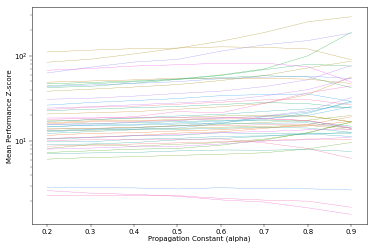

In [22]:
s4b_data = test_df.groupby(['Network', 'alpha']).Performance.mean().reset_index()
sns.lineplot(s4b_data, x='alpha', y='Performance', hue='Network', linewidth=0.3, legend=False)
plt.yscale('log')
plt.xlabel('Propagation Constant (alpha)')
plt.ylabel('Mean Performance Z-score')
plt.savefig(os.path.join(figdir, 'AppendixFigS4B_1.jpg'), bbox_inches='tight', dpi=400)

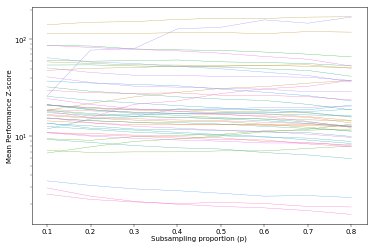

In [23]:
s4b_data = test_df.groupby(['Network', 'p']).Performance.mean().reset_index()
sns.lineplot(s4b_data, x='p', y='Performance', hue='Network', linewidth=0.3, legend=False)
plt.yscale('log')
plt.xlabel('Subsampling proportion (p)')
plt.ylabel('Mean Performance Z-score')
plt.savefig(os.path.join(figdir, 'AppendixFigS4B_2.jpg'), bbox_inches='tight', dpi=400)

### Appendix Figure S4C

Multiple regression of parameters and network size

In [9]:
def alpha_p_optimize_all(data, k=5):
    gs_vals = list(data['Gene Set'].unique())
    net_vals = list(data['net'].unique())
    results = {'net':[], 'geneset':[], 'alpha':[], 'p':[]}
    for g in tqdm(gs_vals):
        for net in net_vals:
            results['net'].append(net)
            results['geneset'].append(g)
            a, p = average_best_params(data[(data.net==net) & (data['Gene Set']==g)], k=k)
            results['alpha'].append(a)
            results['p'].append(p)
    return pd.DataFrame(results).dropna()
            
def average_best_params(data, k=5):
    topk = data.sort_values(by='logPerf', ascending=False).iloc[0:k]
    return topk.alpha.mean(), topk.p.mean()
    
res_all = alpha_p_optimize_all(test_df, k =5)

100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


In [10]:
size_df = test_df.loc[:, ('Norm_NetSize', 'net', 'Gene Set', 'Norm_Coverage')].drop_duplicates()

In [11]:
x = res_all.merge(size_df, left_on=['net', 'geneset'], right_on=['net', 'Gene Set']).groupby('Norm_Coverage').mean()
x['Coverage'] = x.index

First, fit the sampling coefficient

In [12]:
from sklearn import linear_model
from sklearn import preprocessing
# correct Performance for Coverage and NetSize

def calculate_linear_model(x_vals, coefs, intercept):
    x_vals['fit'] = intercept + x_vals.apply(lambda x: np.sum([coefs[i]*x.iloc[i] for i in range(len(coefs))]), axis=1)
    
    return x_vals

def fit_linear_model(test_df, y_col='logPerf', x_cols=['Norm_Coverage', 'Norm_NetSize', 'alpha', 'p'], **kwargs):

    y = test_df[y_col]
    X = test_df[x_cols]

    regr = linear_model.HuberRegressor()
    regr.fit(X, y)

    print('Coefficients:',  ('=%5.3f, '.join(x_cols)+ '=%5.3f') % tuple(regr.coef_))
    #'Coverage=%5.3f, Size=%5.3f, alpha=%5.3f, p=%5.3f' % tuple(regr.coef_))
    print('Intercept: ', regr.intercept_)

# use fit to regress out effects from y
    y_pred = regr.predict(X)
    test_df['Adj'+y_col] = y - y_pred
    test_df['Predicted'+y_col] = y_pred
    print('Correlation: ', y.corr(pd.Series(y_pred)))
    _, axs = plt.subplots(nrows=1, ncols=1+len(x_cols), figsize=(6,2))
    fit_data = calculate_linear_model(X, regr.coef_, regr.intercept_)
    for i, ax in enumerate(axs[1:]):
        sns.scatterplot(data=test_df, x=x_cols[i], y=y_col, ax=ax, s=3)
        sns.lineplot(data=fit_data.sort_values(by=x_cols[i]), x=x_cols[i], y='fit', color='green', ax=ax, **kwargs)
    
    sns.scatterplot(x=y, y=y_pred, alpha=0.7, ax=axs[0], s=3)
    axs[0].set_title('Predicted versus actual')
    return test_df, regr.coef_, regr.intercept_


Coefficients: Norm_NetSize=0.027, Coverage=-0.252
Intercept:  0.45386217849985155
Correlation:  -0.9999999999999998


/tmp/ipykernel_2865187/1292221912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_vals['fit'] = intercept + x_vals.apply(lambda x: np.sum([coefs[i]*x.iloc[i] for i in range(len(coefs))]), axis=1)


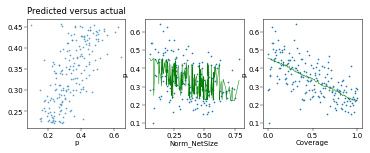

In [24]:
fit_data, p_coefs, p_intercept = fit_linear_model(x, y_col='p', x_cols=['Norm_NetSize', 'Coverage'], linewidth=0.5)
plt.savefig(os.path.join(figdir, 'AppendixFigS4C.jpg'), bbox_inches='tight', dpi=400)

In [14]:
size_correction = test_df.NetSize.max() - test_df.NetSize.min()
coverage_correction = test_df['Gene Set Coverage'].max() - test_df['Gene Set Coverage'].min()

In [15]:
print(f'Size coeff: {p_coefs[0]/size_correction:.4f}')
print(f'Coverage coeff: {p_coefs[1]/coverage_correction:.4f}')

Size coeff: 0.0093
Coverage coeff: -0.0013


### Appendix Figure S4D

In [16]:
# First get the fitted p values
y = res_all.merge(size_df, left_on=['net', 'geneset'], right_on=['net', 'Gene Set'])
y['fitted_p'] = calculate_linear_model(y[['Norm_NetSize', 'Norm_Coverage']], p_coefs, p_intercept).fit

/tmp/ipykernel_2865187/1292221912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_vals['fit'] = intercept + x_vals.apply(lambda x: np.sum([coefs[i]*x.iloc[i] for i in range(len(coefs))]), axis=1)


Coefficients: Norm_NetSize=-0.171, Norm_Coverage=0.073, fitted_p=0.245
Intercept:  0.5902129873616934
Correlation:  nan


/tmp/ipykernel_2865187/1292221912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_vals['fit'] = intercept + x_vals.apply(lambda x: np.sum([coefs[i]*x.iloc[i] for i in range(len(coefs))]), axis=1)


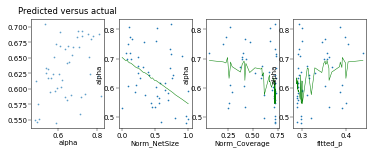

In [17]:
_, a_coefs, a_intercept = fit_linear_model(y.groupby('net').mean(), y_col='alpha', x_cols=['Norm_NetSize', 'Norm_Coverage', 'fitted_p'], linewidth=0.5)
plt.savefig(os.path.join(figdir, 'AppendixFigS4D.jpg'), bbox_inches='tight', dpi=400)

In [18]:
print(f'Size coeff: {a_coefs[0]/size_correction:.3f}')
print(f'Coverage coeff: {a_coefs[1]/coverage_correction:.5f}')
print(f'p coeff: {a_coefs[2]:.3f}')

Size coeff: -0.058
Coverage coeff: 0.00036
p coeff: 0.245
